In [1]:
!pip3 install tokenizers
!pip3 install transformers

     |████████████████████████████████| 3.3 MB 4.9 MB/s 
     |████████████████████████████████| 3.3 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 34.9 MB/s 
     |████████████████████████████████| 61 kB 571 kB/s 
     |████████████████████████████████| 596 kB 42.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("dontpatronizeme_pcl.csv")
df["Category"].replace({2: 1, 3: 1, 4: 1}, inplace=True)

In [ ]:
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.dropna(subset = ["text"], inplace=True)
df.head()

,1,Id,Keywords,country,text,Category
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0


In [ ]:
train_size = int(0.8 * len(df))
shuffle_df = df.sample(frac=1)
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:]

In [ ]:
train_set.head()

,1,Id,Keywords,country,text,Category
2629,2630,@@19994714,hopeless,my,I was there . Not enough seats for spectators ...,0
10293,10294,@@60094448,immigrant,pk,As far as the current refugee issue is concern...,0
7455,7456,@@15250177,hopeless,us,Though the problem of retaining black teachers...,0
2336,2337,@@8213179,migrant,lk,"In both the Paris and Brussels massacres , sev...",0
413,414,@@16051481,in-need,ie,"Meanwhile , the deputy chief executive of Dubl...",1


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 32
EPOCHS = 10

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

Number of replicas: 1


In [ ]:
X_data = df[['text']].to_numpy().reshape(-1)
y_data = df[['Category']].to_numpy().reshape(-1)

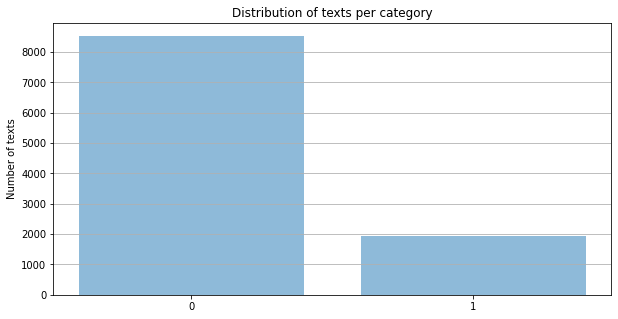

Counter({0: 8528, 1: 1940})


In [ ]:
categories = df[['Category']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
def calculate_stats(df, split_char=' '):
    categories = df['Category'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['text']
        text1 = re.sub(r"\s+", ' ', text)
        text2 = text1.split(split_char)
        l = len(text2)
        
        category = row['Category']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['Category'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')

    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [ ]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
0,"[123, 41, 27, 30, 53, 75, 50, 39, 54, 79, 49, ...",47.423546,28.366171
1,"[26, 41, 10, 23, 20, 53, 124, 45, 51, 30, 65, ...",52.838660,31.706448


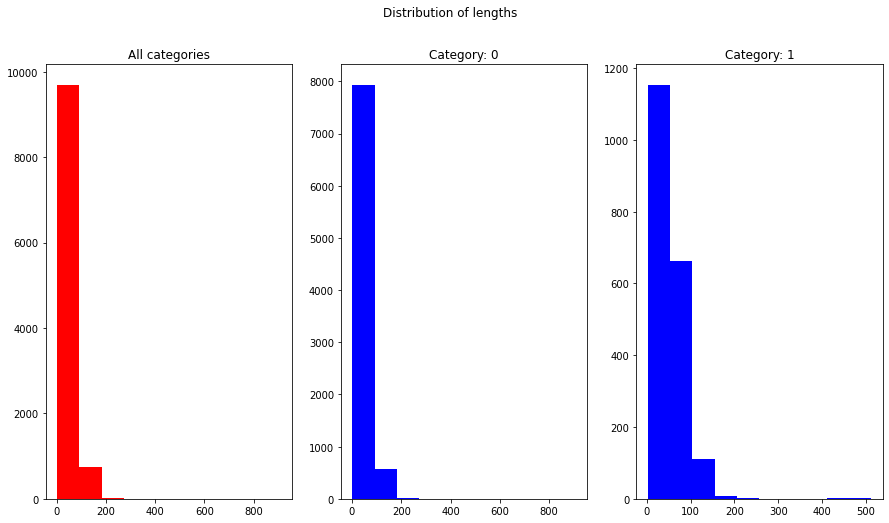

In [ ]:
display_lengths_histograms(df_stats)

In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['Category'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 10468
Number of categories: 2
Done!


In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32')

    for k, text in enumerate(texts):
        tok_text = tokenizer.tokenize(text)

        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        attention_mask[k,:input_length] = 1
        
    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id
category_to_name

{0: 0, 1: 1}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [ ]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [ ]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(y_train),
    y = y_train 
))) 

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=20,
                        verbose=1,
                        class_weight=class_weights,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/10
367/367 [==============================] - 845s 2s/step - loss: 0.5209 - accuracy: 0.7313 - val_loss: 0.3492 - val_accuracy: 0.8500
Epoch 2/10
367/367 [==============================] - 825s 2s/step - loss: 0.3696 - accuracy: 0.8208 - val_loss: 0.3758 - val_accuracy: 0.8198
Epoch 3/10
367/367 [==============================] - 824s 2s/step - loss: 0.2287 - accuracy: 0.8926 - val_loss: 0.4302 - val_accuracy: 0.8182
Epoch 4/10
367/367 [==============================] - 824s 2s/step - loss: 0.1283 - accuracy: 0.9430 - val_loss: 0.4600 - val_accuracy: 0.8211
Epoch 5/10
367/367 [==============================] - 824s 2s/step - loss: 0.0818 - accuracy: 0.9674 - val_loss: 0.4558 - val_accuracy: 0.8418
Epoch 6/10
367/367 [==============================] - 824s 2s/step - loss: 0.0514 - accuracy: 0.9795 - val_loss: 0.4972 - val_accuracy: 0.8427
Epoch 7/10
367/367 [==============================] - 824s 2s/step - loss: 0.0345 - accuracy: 0.9862 - val_loss: 0.5782 - val_accu

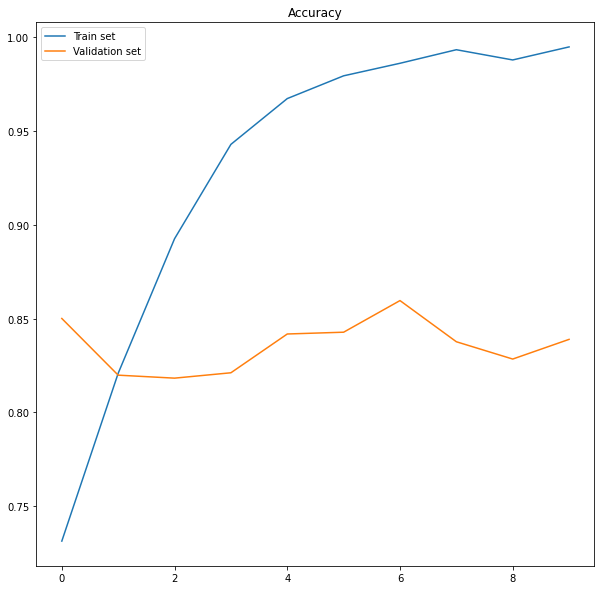

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]
    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 83.89%


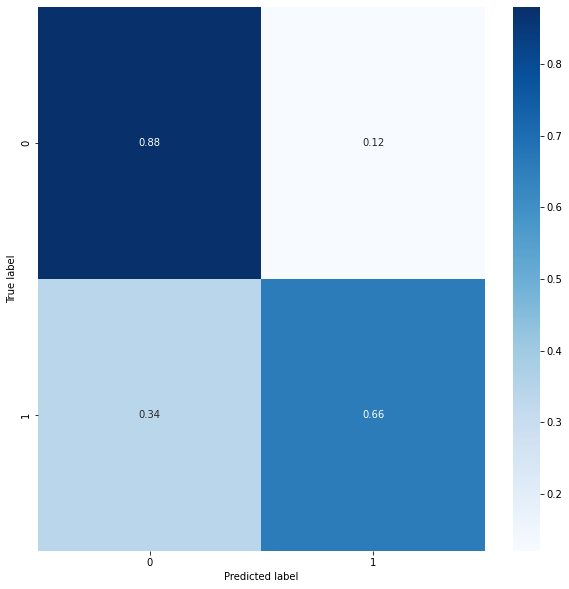

In [ ]:
plot_confusion_matrix(X_test, y_test, model)

In [ ]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2559
           1       0.55      0.66      0.60       582

    accuracy                           0.84      3141
   macro avg       0.74      0.77      0.75      3141
weighted avg       0.85      0.84      0.84      3141

